In [1]:
%load_ext autoreload
%autoreload 2

import evaluation
import numpy as np
import pandas as pd
import os
import visualization as vis
import mir_eval
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

def rename(df, name):
    return df.rename(index={
        'Voicing Recall': 'VR ({})'.format(name),
        'Voicing Accuracy': 'VA ({})'.format(name),
        'Voicing False Alarm': 'VFA ({})'.format(name),
        'Overall Accuracy': 'OA ({})'.format(name),
        'Raw Pitch Accuracy': 'RPA ({})'.format(name),
        'Raw Chroma Accuracy': 'RCA ({})'.format(name)
    }, columns={
        "MIREX05 train.": "MIREX05",
        "MedleyDB": "MedleyDB test",
        "MDB-mel-s.": "MDB-mel-s.",
        "WJazzD": "WJazzD test",
    })

def drop_valid(df):
    return df.drop(list(df.filter(regex = 'valid.')), axis = 1)

def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    # data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

def highlight_min(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    # data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.min()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

    
    
from common_jupyter import to_latex

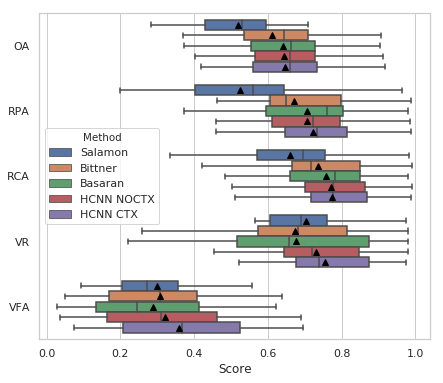

In [2]:
import seaborn as sns
sns.set(rc={'figure.figsize': (7, 6)})
sns.set(style="whitegrid")

full_res = []

data = evaluation.results("salamon", "../algoritmy/melodia-salamon2012/", ".txt")
data["Method"] = "Salamon"
full_res.append(data)

data = evaluation.results("deepsalience", "../algoritmy/ismir2017-deepsalience-f0-outputs/", "_melody2_singlef0.csv")
data["Method"] = "Bittner"
full_res.append(data)

data = evaluation.results("basaran", "../algoritmy/ismir2018_dominant_melody_estimation-f0-outputs/", ".csv")
data["Method"] = "Basaran"
full_res.append(data)

# results_path = "./models/0506_222602-crepe-bs32-lr0.001-lrd0.75-lrds50000-cm8-mc5-vsFalse/model-f0-outputs/"
# data = evaluation.results("test", results_path, ".csv")
# data["Method"] = "CREPE"
# full_res.append(data)

# results_path = "./models/0501_040822-wavenet-fw160-cw8192-apw5-lrd0.8-lrds10000-ifw0-ifpsame-fw3-ubTrue-sc16-rc16-sn2-md1024-dld0.0-sld0.0-sconcat-pavgpool_p5_s5_Psame--conv_f180_k16_s4_Psame_arelu--conv_f360_k64_s8_Psame/model-f0-outputs/"
# data = evaluation.results("test", results_path, ".csv")
# data["Method"] = "WaveNet"
# full_res.append(data)

# data = evaluation.results("test", "./models/0513_173718-spctrgrm-bs16-fw256-apw1-ulw1.0-sus8-sos8-f16-s8-us2-os3/model-f0-outputs/", ".csv")
# data["Method"] = "HCNN noctx"
# full_res.append(data)

# data = evaluation.results("test", "./models/0513_114331-spctrgrm-bs8-fw256-cw3072-apw10-ulw1.0-scqt_fs-sus8-sos8-cc0-f16-s4-us1-os2-cc-3,-3,-3,-1-d-8,-4,-2,-1-sp0.75//model-f0-outputs", ".csv")
# data["Method"] = "HCNN"
# full_res.append(data)

data = evaluation.results("test", "models-noctx/0926_024712-spctrgrm-fw256-apw1-lr0.0005-ulw1.0-scqt-std110.0-sus8-sos8-f12-s8-us3-os5/model-f0-outputs/", ".csv")
data["Method"] = "HCNN noctx"
full_res.append(data)

data = evaluation.results("test", "models/0929_112608-spctrgrm-bs16-fw256-cw3072-apw10-ulw1.0-std110.0-sus8-sos8-cc0-f8-s4-us5-os6-cc-3,-3,-3,-1-d-8,-4,-2,-1/model-f0-outputs", ".csv")
data["Method"] = "HCNN"
full_res.append(data)


full_res = pd.concat(full_res)
full_res = full_res[full_res.Split == "test"]

full_res = full_res.replace({
    "MIREX05 train.": "MIREX05",
    "MDB-mel-s.": "MDB-m-s"
})

#results_nice = list(map(drop_valid, results_nice))
#display(full_res)
melted = pd.melt(full_res, ("Method","Dataset", "Track", "Prefix", "Split", ))
melted = melted[melted.Dataset=="MedleyDB"]
melted = melted[melted.variable!="Voicing Accuracy"]
#melted = melted[melted.variable!="Voicing False Alarm"]
#display(full_res)

# sns.catplot(x="value", y="Dataset", hue="Method", data=melted, col="variable", kind="box",
#             meanprops={"markerfacecolor": "black", "markeredgecolor": "black"}, fliersize=2, showmeans=True, showfliers=False)

melted = melted.replace({
        'Voicing Recall': 'VR',
        'Voicing False Alarm': 'VFA',
        'Overall Accuracy': 'OA',
        'Raw Pitch Accuracy': 'RPA',
        'Raw Chroma Accuracy': 'RCA',
        "HCNN noctx": "HCNN NOCTX",
        "HCNN": "HCNN CTX",
    })
ax = sns.boxplot(x="value", y="variable", hue="Method", data=melted,
            meanprops={"markerfacecolor": "black", "markeredgecolor": "black"}, fliersize=2, showmeans=True, showfliers=False,
                order=["OA", "RPA", "RCA", "VR", "VFA"])
ax.set(xlabel='Score', ylabel='')

#results_concat = pd.concat([results_hcnn_noctx, results_bittner, results_basaran, results_hcnn])
#melted = pd.melt(results_concat, ("Method","Dataset", "Track", "Prefix", "Split", ))
#melted = melted[melted.Dataset=="MedleyDB"]
#melted = melted[melted.variable!="Voicing Accuracy"]
#melted = melted[melted.variable!="Voicing False Alarm"]

plt.savefig("figures/medleydb_scores_sota.pdf", bbox_inches="tight")

In [5]:
results = []
# === Bosch ====
# summary_bosch = evaluation.summary("bosch", "../algoritmy/SourceFilterContoursMelody/src/", ".txt")
# results.append((summary_bosch, "Bosch"))
# === Salamon ===
summary_salamon = evaluation.summary("salamon", "../algoritmy/melodia-salamon2012/", ".txt")
results.append((summary_salamon, "Salamon"))
# === Bittner ===
summary_bittner = evaluation.summary("deepsalience", "../algoritmy/ismir2017-deepsalience-f0-outputs/", "_melody2_singlef0.csv")
results.append((summary_bittner, "Bittner"))
# === Basaran ===
summary_basaran = evaluation.summary("basaran", "../algoritmy/ismir2018_dominant_melody_estimation-f0-outputs/", ".csv")
results.append((summary_basaran, "Basaran"))
# === HCNN noctx ===
#results_path = "./models/0513_173718-spctrgrm-bs16-fw256-apw1-ulw1.0-sus8-sos8-f16-s8-us2-os3/model-f0-outputs/"
#s = evaluation.summary("test", results_path, ".csv")
#results.append((s, "HCNN noctx_old"))
# === HCNN ctx ===
#results_path = "./models/0513_114331-spctrgrm-bs8-fw256-cw3072-apw10-ulw1.0-scqt_fs-sus8-sos8-cc0-f16-s4-us1-os2-cc-3,-3,-3,-1-d-8,-4,-2,-1-sp0.75//model-f0-outputs"
#s = evaluation.summary("test", results_path, ".csv")
#results.append((s, "HCNN_old"))
# === HCNN noctx ===
results_path = "./models/0926_024712-spctrgrm-fw256-apw1-lr0.0005-ulw1.0-scqt-std110.0-sus8-sos8-f12-s8-us3-os5/model-f0-outputs/"
s = evaluation.summary("test", results_path, ".csv")
results.append((s, "HCNN noctx"))
# === HCNN ctx ===
results_path = "./models/0929_112608-spctrgrm-bs16-fw256-cw3072-apw10-ulw1.0-std110.0-sus8-sos8-cc0-f8-s4-us5-os6-cc-3,-3,-3,-1-d-8,-4,-2,-1/model-f0-outputs"
s = evaluation.summary("test", results_path, ".csv")
results.append((s, "HCNN"))

results_nice = list(map(lambda res_name: rename(*res_name), results))
results_nice = list(map(drop_valid, results_nice))

In [7]:
results_OA = list(map(lambda res: res[4:5], results_nice))
OA = pd.concat(results_OA)
#to_latex(OA)
OA.style.apply(highlight_max)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
OA (Salamon),0.713797,0.526605,0.71452,0.518983,0.23484,0.66701
OA (Bittner),0.715937,0.632738,0.701514,0.610536,0.407476,0.691608
OA (Basaran),0.668765,0.689269,0.734208,0.640077,0.482725,0.700011
OA (HCNN noctx),0.73481,0.635707,0.727818,0.644945,0.457179,0.71434
OA (HCNN),0.745511,0.637283,0.704188,0.646126,0.525249,0.711085


In [8]:
results_RPA = list(map(lambda res: res[2:3], results_nice))
#dressler = pd.DataFrame({'ADC04': {'RPA (Dressler)': 0.892},
# 'MIREX05 train.': {'RPA (Dressler)': 0.739},
# 'ORCHSET': {'RPA (Dressler)': 0.494}})
#results_RPA = pd.concat([dressler]+results_RPA)
RPA = pd.concat(results_RPA)
#to_latex(RPA)
RPA.style.apply(highlight_max)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
RPA (Salamon),0.767063,0.513802,0.760712,0.525844,0.280616,0.693208
RPA (Bittner),0.814213,0.605959,0.806656,0.670104,0.518621,0.773577
RPA (Basaran),0.79281,0.733417,0.797663,0.706123,0.634579,0.767087
RPA (HCNN noctx),0.836104,0.66068,0.819254,0.706893,0.530169,0.802417
RPA (HCNN),0.851786,0.687351,0.812434,0.723557,0.601893,0.810263


In [9]:
results_RCA = map(lambda res: res[3:4], results_nice)
RCA = pd.concat(results_RCA)
#to_latex(RCA)
#RCA.mean(axis=1)#.style.apply(highlight_max)
RCA.style.apply(highlight_max)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
RCA (Salamon),0.807158,0.638538,0.805127,0.659059,0.568139,0.757013
RCA (Bittner),0.854935,0.666314,0.823713,0.735406,0.693707,0.785256
RCA (Basaran),0.819725,0.766182,0.807263,0.757161,0.775899,0.77586
RCA (HCNN noctx),0.869939,0.709174,0.83094,0.771275,0.692334,0.81882
RCA (HCNN),0.884186,0.72508,0.821927,0.774309,0.752309,0.819949


In [11]:
results = map(lambda res: res[0:1], results_nice)
results = pd.concat(results)
#to_latex(results)
results.style.apply(highlight_max)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
VR (Salamon),0.774355,0.72896,0.841203,0.704866,0.603481,0.794325
VR (Bittner),0.796281,0.637848,0.79562,0.674784,0.614044,0.845741
VR (Basaran),0.731616,0.704252,0.713345,0.676128,0.604956,0.841437
VR (HCNN noctx),0.794724,0.68717,0.810546,0.731176,0.72794,0.877918
VR (HCNN),0.8154,0.732943,0.834809,0.754479,0.796396,0.888697


In [12]:
results = map(lambda res: res[1:2], results_nice)
results = pd.concat(results)
#to_latex(results)
results.style.apply(highlight_min)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
VFA (Salamon),0.10304,0.394134,0.263022,0.300236,0.38522,0.271176
VFA (Bittner),0.277807,0.273239,0.307966,0.306484,0.490377,0.332989
VFA (Basaran),0.188417,0.270503,0.159533,0.289879,0.406912,0.273853
VFA (HCNN noctx),0.242749,0.302006,0.305154,0.321345,0.537064,0.336843
VFA (HCNN),0.254764,0.329214,0.373504,0.359704,0.60897,0.360444


In [13]:
results = map(lambda res: res[5:6], results_nice)
results = pd.concat(results)
#to_latex(results)
results.style.apply(highlight_max)

Dataset,ADC04,MDB-mel-s.,MIREX05,MedleyDB test,ORCHSET,WJazzD test
VA (Salamon),0.783239,0.650707,0.793238,0.679516,0.603119,0.764142
VA (Bittner),0.774727,0.710791,0.755063,0.698228,0.610466,0.778311
VA (Basaran),0.734001,0.759531,0.776719,0.72828,0.6092,0.798383
VA (HCNN noctx),0.778656,0.715905,0.771178,0.740409,0.711374,0.796296
VA (HCNN),0.795616,0.720725,0.761014,0.742063,0.769147,0.793773


# Bachelor thesis figures

In [25]:
results_bittner = evaluation.results("deepsalience", "../algoritmy/ismir2017-deepsalience-f0-outputs/", "_melody2_singlef0.csv")
results_bittner["Method"] = "Bittner"
results_basaran = evaluation.results("basaran", "/home/jirka/bakalarka/algoritmy/ismir2018_dominant_melody_estimation-f0-outputs", ".csv")
results_basaran["Method"] = "Basaran"
results_hcnn = evaluation.results("test", "./models/0513_114331-spctrgrm-bs8-fw256-cw3072-apw10-ulw1.0-scqt_fs-sus8-sos8-cc0-f16-s4-us1-os2-cc-3,-3,-3,-1-d-8,-4,-2,-1-sp0.75/model-f0-outputs", ".csv")
results_hcnn["Method"] = "HCNN"
results_hcnn_noctx = evaluation.results("test", "./models/0513_173718-spctrgrm-bs16-fw256-apw1-ulw1.0-sus8-sos8-f16-s8-us2-os3/model-f0-outputs/", ".csv")
results_hcnn_noctx["Method"] = "HCNN noctx"

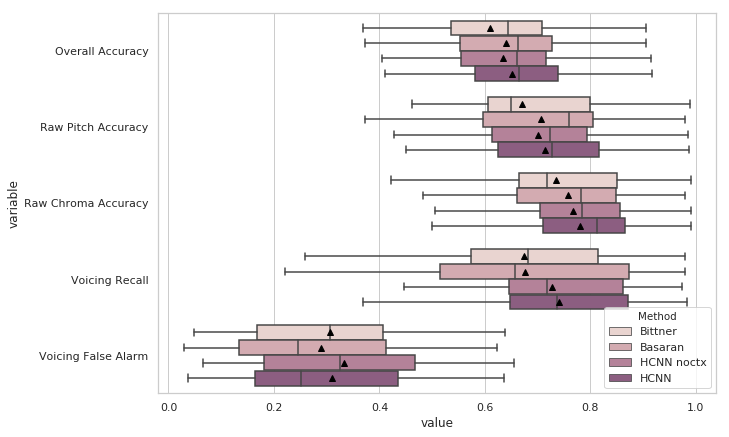

In [26]:
sns.set(rc={'figure.figsize': (10, 7)})
sns.set(style="whitegrid")

results_concat = pd.concat([results_hcnn_noctx, results_bittner, results_basaran, results_hcnn])
melted = pd.melt(results_concat, ("Method","Dataset", "Track", "Prefix", "Split", ))
melted = melted[melted.Dataset=="MedleyDB"]
melted = melted[melted.variable!="Voicing Accuracy"]
#melted = melted[melted.variable!="Voicing False Alarm"]
palette = sns.cubehelix_palette(6)
sns.boxplot(y="variable", x="value", hue="Method", data=melted, hue_order=("Bittner", "Basaran", "HCNN noctx", "HCNN"), fliersize=2, palette=palette, showmeans=True, showfliers=False,
           meanprops={"markerfacecolor": "black", "markeredgecolor": "black"}, order=("Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy", "Voicing Recall", "Voicing False Alarm"))
#results_concatmelted
plt.savefig("figures/final_medleydb.pdf", bbox_inches="tight")

In [27]:
results_all = results_hcnn.copy()
results_all["Bittner RPA"] = results_bittner["Raw Pitch Accuracy"]
results_all["Basaran RPA"] = results_basaran["Raw Pitch Accuracy"]
results_all["HCNN RPA"] = results_hcnn["Raw Pitch Accuracy"]
results_all["HCNN noctx RPA"] = results_hcnn_noctx["Raw Pitch Accuracy"]

results_all["Bittner RPA Diff"] = results_bittner["Raw Pitch Accuracy"] - results_all["Raw Pitch Accuracy"]
results_all["Basaran RPA Diff"] = results_basaran["Raw Pitch Accuracy"] - results_all["Raw Pitch Accuracy"]
results_all["HCNN noctx RPA Diff"] = results_hcnn_noctx["Raw Pitch Accuracy"] - results_all["Raw Pitch Accuracy"]


results_all["Bittner RCA"] = results_bittner["Raw Chroma Accuracy"]
results_all["Basaran RCA"] = results_basaran["Raw Chroma Accuracy"]
results_all["HCNN RCA"] = results_hcnn["Raw Chroma Accuracy"]
results_all["HCNN noctx RCA"] = results_hcnn_noctx["Raw Chroma Accuracy"]

results_all["Bittner RCA Diff"] = results_bittner["Raw Chroma Accuracy"] - results_all["Raw Chroma Accuracy"]
results_all["Basaran RCA Diff"] = results_basaran["Raw Chroma Accuracy"] - results_all["Raw Chroma Accuracy"]
results_all["HCNN noctx RCA Diff"] = results_hcnn_noctx["Raw Chroma Accuracy"] - results_all["Raw Chroma Accuracy"]


In [28]:
# korelace
res_pitch = results_all[["HCNN RPA", "HCNN RCA", "Bittner RPA", "Bittner RCA", "Basaran RPA", "Basaran RCA", "HCNN noctx RPA", "HCNN noctx RCA"]]
res_pitch.corr()
#res_pitch = results_all[["HCNN RPA", "Bittner RPA", "Basaran RPA"]]
#sns.pairplot(res_pitch)

#sns.scatterplot(x="HCNN RPA", y="Bittner RPA", data=results_all[results_all.Dataset=="ORCHSET"])

,HCNN RPA,HCNN RCA,Bittner RPA,Bittner RCA,Basaran RPA,Basaran RCA,HCNN noctx RPA,HCNN noctx RCA
HCNN RPA,1.000000,0.782903,0.932438,0.741028,0.735952,0.442404,0.975920,0.840499
HCNN RCA,0.782903,1.000000,0.744468,0.913312,0.646016,0.693847,0.782640,0.965115
Bittner RPA,0.932438,0.744468,1.000000,0.824437,0.692152,0.429889,0.932592,0.817692
Bittner RCA,0.741028,0.913312,0.824437,1.000000,0.619944,0.646776,0.762318,0.914917
Basaran RPA,0.735952,0.646016,0.692152,0.619944,1.000000,0.774141,0.727771,0.673535
Basaran RCA,0.442404,0.693847,0.429889,0.646776,0.774141,1.000000,0.433405,0.648547
HCNN noctx RPA,0.975920,0.782640,0.932592,0.762318,0.727771,0.433405,1.000000,0.874149
HCNN noctx RCA,0.840499,0.965115,0.817692,0.914917,0.673535,0.648547,0.874149,1.000000


In [29]:
# korelace
res_pitch = results_all[results_all.Dataset!="ORCHSET"][["HCNN RPA", "HCNN RCA", "Bittner RPA", "Bittner RCA", "Basaran RPA", "Basaran RCA", "HCNN noctx RPA", "HCNN noctx RCA"]]
res_pitch.corr()
#res_pitch = results_all[["HCNN RPA", "Bittner RPA", "Basaran RPA"]]
#sns.pairplot(res_pitch)

#sns.scatterplot(x="HCNN RPA", y="Bittner RPA", data=results_all[results_all.Dataset=="ORCHSET"])

,HCNN RPA,HCNN RCA,Bittner RPA,Bittner RCA,Basaran RPA,Basaran RCA,HCNN noctx RPA,HCNN noctx RCA
HCNN RPA,1.000000,0.943525,0.925213,0.912360,0.671421,0.588251,0.982470,0.942781
HCNN RCA,0.943525,1.000000,0.862060,0.931967,0.693611,0.681066,0.936892,0.981986
Bittner RPA,0.925213,0.862060,1.000000,0.959244,0.598751,0.513691,0.923359,0.870807
Bittner RCA,0.912360,0.931967,0.959244,1.000000,0.635054,0.606195,0.911207,0.926522
Basaran RPA,0.671421,0.693611,0.598751,0.635054,1.000000,0.962868,0.667778,0.686779
Basaran RCA,0.588251,0.681066,0.513691,0.606195,0.962868,1.000000,0.586561,0.667428
HCNN noctx RPA,0.982470,0.936892,0.923359,0.911207,0.667778,0.586561,1.000000,0.962422
HCNN noctx RCA,0.942781,0.981986,0.870807,0.926522,0.686779,0.667428,0.962422,1.000000


In [34]:
results_all["RCA sum"] = results_all["Bittner RCA Diff"] + results_all["Basaran RCA Diff"]
results_all["RCA all sum"] = results_all["Raw Chroma Accuracy"] + results_all["Bittner RCA"] + results_all["Basaran RCA"] + results_all["HCNN noctx RCA"]
results_all["RPA all sum"] = results_all["Raw Chroma Accuracy"] + results_all["Bittner RPA"] + results_all["Basaran RPA"] + results_all["HCNN noctx RPA"]

res = results_all.sort_values("HCNN RPA")
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(res)

,Voicing Recall,Voicing False Alarm,Raw Pitch Accuracy,Raw Chroma Accuracy,Overall Accuracy,Voicing Accuracy,Track,Prefix,Split,Dataset,Method,Bittner RPA,Basaran RPA,HCNN RPA,HCNN noctx RPA,Bittner RPA Diff,Basaran RPA Diff,HCNN noctx RPA Diff,Bittner RCA,Basaran RCA,HCNN RCA,HCNN noctx RCA,Bittner RCA Diff,Basaran RCA Diff,HCNN noctx RCA Diff,RCA sum,RCA all sum,RPA all sum
21,0.235469,0.106918,0.071038,0.390462,0.081492,0.283610,Grieg-PeerGynt-HallMountainKing-ex1,orchset,test,ORCHSET,HCNN,0.165425,0.101341,0.071038,0.076503,0.094386,0.030303,0.005464,0.345256,0.381023,0.390462,0.345256,-0.045206,-0.009439,-0.045206,-0.054645,1.461997,0.733731
9,0.897445,0.738636,0.134395,0.900037,0.124059,0.877375,Beethoven-S7-II-ex2,orchset,test,ORCHSET,HCNN,0.099593,0.314698,0.134395,0.229545,-0.034802,0.180304,0.095150,0.881896,0.825620,0.900037,0.788597,-0.018141,-0.074417,-0.111440,-0.092558,3.396150,1.543873
34,0.519442,0.103448,0.140321,0.473795,0.056367,0.524008,Musorgski-Ravel-PicturesExhibition-ex11,orchset,test,ORCHSET,HCNN,0.164835,0.208791,0.140321,0.114117,0.024514,0.068470,-0.026205,0.473373,0.550719,0.473795,0.439983,-0.000423,0.076923,-0.033812,0.076500,1.937870,0.961538
37,0.544434,0.203390,0.196445,0.813845,0.125443,0.557624,Musorgski-Ravel-PicturesExhibition-ex6,orchset,test,ORCHSET,HCNN,0.396632,0.040225,0.196445,0.103368,0.200187,-0.156221,-0.093078,0.826473,0.913938,0.813845,0.759121,0.012629,0.100094,-0.054724,0.112722,3.313377,1.354069
5,0.316190,0.270559,0.202195,0.583032,0.460081,0.554873,MatthewEntwistle_FairerHopes_STEM_14.RESYN,mdb_melody_synth,test,MDB-mel-s.,HCNN,0.007981,0.643403,0.202195,0.327075,-0.194214,0.441207,0.124880,0.349668,0.822502,0.583032,0.599223,-0.233364,0.239469,0.016190,0.006106,2.354425,1.561491
10,0.857160,0.746364,0.210472,0.263380,0.202519,0.727102,MusicDelta_Pachelbel_STEM_04.RESYN,mdb_melody_synth,test,MDB-mel-s.,HCNN,0.221664,0.205315,0.210472,0.197911,0.011193,-0.005156,-0.012561,0.263429,0.267669,0.263380,0.251112,0.000049,0.004289,-0.012268,0.004338,1.045589,0.888270
1,0.818648,0.673077,0.225410,0.375000,0.204280,0.793774,Beethoven-S3-I-ex2,orchset,test,ORCHSET,HCNN,0.311475,0.563525,0.225410,0.198770,0.086066,0.338115,-0.026639,0.422131,0.744877,0.375000,0.354508,0.047131,0.369877,-0.020492,0.417008,1.896516,1.448770
39,0.882943,0.618182,0.227843,0.909699,0.197793,0.871680,Musorgski-Ravel-PicturesExhibition-ex8,orchset,test,ORCHSET,HCNN,0.213211,0.931438,0.227843,0.357023,-0.014632,0.703595,0.129181,0.846990,0.952759,0.909699,0.862040,-0.062709,0.043060,-0.047659,-0.019649,3.571488,2.411371
2,0.476821,0.200883,0.246358,0.578808,0.321956,0.551197,Beethoven-S3-I-ex3,orchset,test,ORCHSET,HCNN,0.217881,0.360265,0.246358,0.207285,-0.028477,0.113907,-0.039073,0.432450,0.618543,0.578808,0.542384,-0.146358,0.039735,-0.036424,-0.106623,2.172185,1.364238
12,0.338446,0.125000,0.263804,0.434560,0.164671,0.351297,Beethoven-S9-II-ex3,orchset,test,ORCHSET,HCNN,0.279141,0.407975,0.263804,0.249489,0.015337,0.144172,-0.014315,0.424335,0.558282,0.434560,0.413088,-0.010225,0.123722,-0.021472,0.113497,1.830266,1.371166


In [35]:
import seaborn as sns
import librosa
import matplotlib.pyplot as plt
import datasets
from datasets.common import hz_to_midi_safe
import visualization as vis
# porovnání výstupů dvou metod
def show_spectrogram(audio_path, annot_path, ax=None):
    if ax is None:
        plt.figure(figsize=(10,5))
    else:
        plt.sca(ax)
    # fig, axs = plt.subplots(1,1, figsize=(10,5))

    audio, sr = librosa.load(audio_path, sr=None)
    
    midi_min = 24
    
    fmin = librosa.core.midi_to_hz(midi_min)
    n_bins = 540
    bins_per_octave = 60
    midi_max = midi_min + n_bins/bins_per_octave*12
    
    cmap = sns.cubehelix_palette(light=0.98, reverse=False, as_cmap=True)
    t, f = mir_eval.io.load_time_series(annot_path, delimiter='\\s+|,')

#     spectrogram = librosa.amplitude_to_db(np.abs(librosa.core.stft(audio, 4096, 64)), ref=np.max)
#     plt.imshow(spectrogram, cmap=cmap, aspect="auto", origin="lower", extent=(0, len(audio)/sr, 0, sr/2))
#     plt.ylim(0, 2000)
    
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.core.cqt(audio, sr, 512, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, filter_scale=1)), ref=np.max)
    plt.imshow(spectrogram, cmap=cmap, aspect="auto", origin="lower", extent=(0, len(audio)/sr, midi_min, midi_max))
    plt.ylim(midi_min, midi_max)
    f = hz_to_midi_safe(f)

    f[f == 0] = None

    plt.plot(t, f-0.7, ".w", markersize=0.5)
#     plt.plot(t, f+22, ".w", markersize=0.5)

    #plt.colorbar(format='%+2.0f dBFS')

    plt.xlabel("Čas (s)")
    plt.ylabel("Tón (MIDI)")

    #plt.tight_layout()
    #plt.show()
    #sns.lineplot(t, f)
    # fig.savefig("../tex/img/audio_mix_stft_2.pdf", bbox_inches="tight")

def show_salience(dataset, track, method, path, xlim=None):
    sal_file = glob("{}/{}-{}-melody-outputs/*{}*".format(path, dataset, method, track))[0]
    
    fig = plt.figure(figsize=(10,5))

    salience = np.load(sal_file).T
    print(salience.shape)
    
    midi_min = 24
    bps = 5
    midi_max = midi_min+salience.shape[0]/bps
    hop_size = 256

    cmap = sns.cubehelix_palette(light=0.98, reverse=False, as_cmap=True)

    #plt.imshow(librosa.amplitude_to_db(salience, ref=np.max), cmap=cmap, aspect="auto", origin="lower", extent=(0, len(salience)/hop_size, midi_min, midi_max))
    plt.imshow(salience, cmap=cmap, aspect="auto", origin="lower", extent=(0, salience.shape[1]*hop_size/44100, midi_min, midi_max))
    plt.ylim(midi_min, midi_max)

    plt.xlabel("Čas (s)")
    plt.ylabel("Tón (MIDI)")

    if xlim is not None:
        plt.xlim(*xlim)

    plt.tight_layout()
    fig.savefig("figures/vysledky/"+dataset+"_"+track+"_salience.pdf", bbox_inches="tight")

def compare(dataset, track, method_tuples, show_spec=False, show_player=False, sonify=False, xlim=None, ylim=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #sns.reset_orig()

    def get_est(dataset, track, method, results_path):
        return glob("{}/{}-{}-melody-outputs/{}*".format(results_path, dataset, method, track))[0]
    def get_ref(dataset, track):
        refs = [track for prefix,_,_,dataset_iter in evaluation.get_dataset_list() if prefix == dataset for track in dataset_iter]
        ref_track = next(x for x in refs if x.track_id in track or track in x.track_id)
        return ref_track

    ref = get_ref(dataset, track)
    if show_player:
        display(vis.audioplayer(ref.audio_path))
    
    ref_time, ref_freq = mir_eval.io.load_time_series(ref.annot_path, delimiter='\\s+|,')
    if sonify:
        display(vis.samplesplayer(mir_eval.sonify.pitch_contour(ref_time, ref_freq, 8000), 8000))

    ests = []
    refs = []
    
    nrows = len(method_tuples) + (1 if show_spec else 0)
    fig, axs = plt.subplots(nrows, 1, sharex=True, sharey=True, squeeze=False, figsize=(10, nrows*1.8))
    axs = axs[:,0]
    
    if show_spec:
        show_spectrogram(ref.audio_path, ref.annot_path, ax=axs[-1])
        axs[-1].set_title("Spektrogram")
        if xlim is not None:
            plt.xlim(*xlim)

    
    ref_freq = np.abs(ref_freq)
    plt.ylim(hz_to_midi_safe(np.min(ref_freq[ref_freq>0]))-13, hz_to_midi_safe(np.max(ref_freq))+13)
    
    for i, (name, method, path) in enumerate(method_tuples):
        est = get_est(dataset, track, method, path)

        ests.append(est)
        refs.append(ref)

    # evaluation.evaluate_melody_paths(refs, ests, per_track_info=True)
    
        filename, (ref_time, ref_freq, est_time, est_freq) = evaluation.load_melody_paths([ref.annot_path], [est])[0]
        est_v = est_freq > 0
        est_freq, est_v = mir_eval.melody.resample_melody_series(est_time, est_freq, est_v, ref_time, "linear")

        # POZOR ODSTRANĚN VOICING
        ref_notes = datasets.common.melody_to_multif0(np.abs(hz_to_midi_safe(ref_freq)))
        est_notes = datasets.common.melody_to_multif0(np.abs(hz_to_midi_safe(est_freq)))
        
        axs[i].set_title(name)
        vis.draw_notes_on_ax(ref_notes, est_notes, ax=axs[i], onlyvoiced=True, ms=2, timescale=(ref_time[1]-ref_time[0]))

    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.tight_layout()
    plt.show()

    fig.savefig("figures/vysledky/"+dataset+"_"+track+".pdf", bbox_inches="tight")

def get_scores(dataset, track):
    def lookup(pd, dataset, track):
        return pd[pd.Track.str.contains(track) & (pd.Prefix==dataset)]
    rb = lookup(results_bittner, dataset, track)
    rb = rename(rb.T, "Bittner")[2:4]
    
    rd = lookup(results_basaran, dataset, track)
    rd = rename(rd.T, "Basaran")[2:4]
    
    rh = lookup(results_hcnn, dataset, track)
    rh = rename(rh.T, "HCNN")[2:4]
    
    rhno = lookup(results_hcnn_noctx, dataset, track)
    rhno = rename(rhno.T, "HCNN noctx")[2:4]
    
    
    res = pd.concat([rhno, rh, rb, rd])
    res.columns = [track]
    res.index.name = "Metrika (Metoda)"
    return res
    
bittner = ("Bittner", "deepsalience", "../algoritmy/ismir2017-deepsalience-f0-outputs/")
basaran = ("Basaran", "basaran", "/home/jirka/bakalarka/algoritmy/ismir2018_dominant_melody_estimation-f0-outputs")
#hcnn = ("test", "./models/0507_154235-spctrgrm-bs16-fw256-cw0-apw1-sus8-sos8-f16-s8-us2-os3/model-f0-outputs/")
bosch = ("bosch", "../algoritmy/SourceFilterContoursMelody/src/")
hcnn = ("HCNN", "test", "./models/0513_114331-spctrgrm-bs8-fw256-cw3072-apw10-ulw1.0-scqt_fs-sus8-sos8-cc0-f16-s4-us1-os2-cc-3,-3,-3,-1-d-8,-4,-2,-1-sp0.75/model-f0-outputs")
hcnn_noctx = ("HCNN noctx", "test", "./models/0513_173718-spctrgrm-bs16-fw256-apw1-ulw1.0-sus8-sos8-f16-s8-us2-os3/model-f0-outputs/")

all_methods = [hcnn, hcnn_noctx, bittner, basaran]

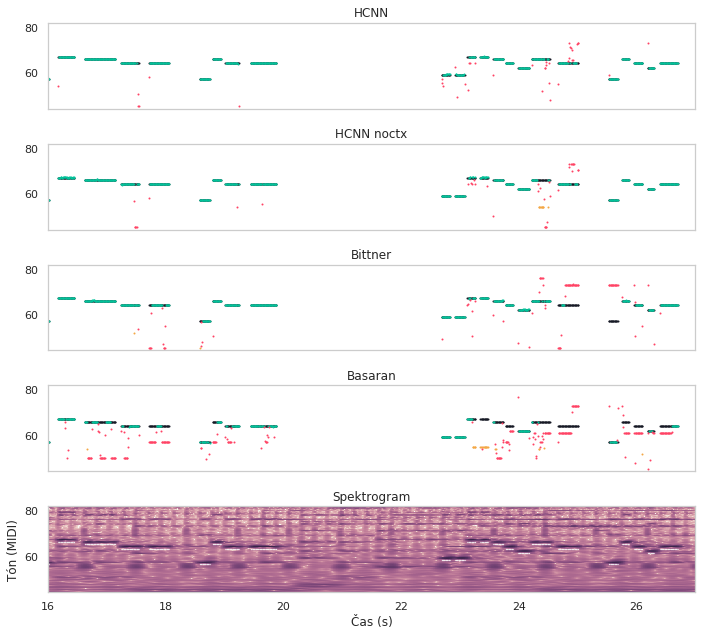

\begin{tabular}{ll}
\toprule
 Metrika (Metoda) & train10 \\
\midrule
 RPA (HCNN noctx) &   0.892 \\
 RCA (HCNN noctx) &   0.918 \\
       RPA (HCNN) &   0.909 \\
       RCA (HCNN) &   0.915 \\
    RPA (Bittner) &   0.863 \\
    RCA (Bittner) &   0.868 \\
    RPA (Basaran) &   0.512 \\
    RCA (Basaran) &   0.572 \\
\bottomrule
\end{tabular}



In [36]:
# Protipříklad Basaran 1
# neslyší MIDI
dataset = "mirex05"
track = "train10"
compare(dataset, track, all_methods, xlim=(16, 27), show_spec=True, show_player=False)
to_latex(get_scores(dataset, track))

../algoritmy/ismir2018_dominant_melody_estimation/predict/train01.h5
Keys: <KeysViewHDF5 ['HF0', 'HGAMMA', 'HM', 'HPHI', 'WM', 'pitch_accuracy']>
(301, 2110)
9.862819157949172e-50
../algoritmy/ismir2018_dominant_melody_estimation/predict/train10.h5
Keys: <KeysViewHDF5 ['HF0', 'HGAMMA', 'HM', 'HPHI', 'WM', 'pitch_accuracy']>
(301, 3360)
4.0542368678076494e-53


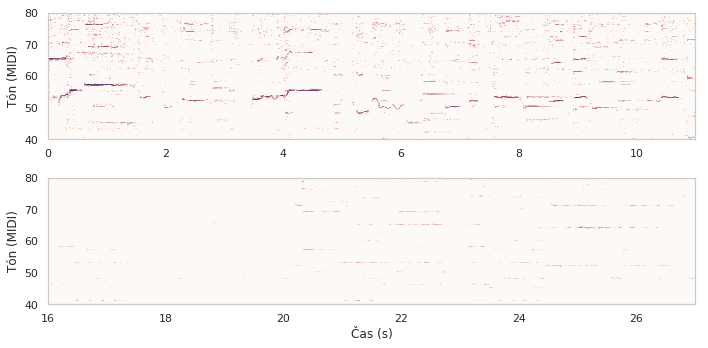

In [37]:
import h5py
track = "train01"

def show_salience_basaran(track):
    sal_file = glob("../algoritmy/ismir2018_dominant_melody_estimation/predict/*{}*".format(track))[0]

    print(sal_file)
    f = h5py.File(sal_file, 'r')

    # List all groups
    print("Keys: %s" % f.keys())
    # a_group_key = list(f.keys())[0]

    # Get the data
    salience = np.array(f["HF0"])
    print(salience.shape)

    midi_min = 24
    bps = 5
    midi_max = midi_min+salience.shape[0]/bps
    hop_size = 512
    print(np.min(salience))
    cmap = sns.cubehelix_palette(light=0.98, reverse=False, as_cmap=True)
    plt.imshow(librosa.amplitude_to_db(salience, ref=np.max), cmap=cmap, aspect="auto", origin="lower", extent=(0, salience.shape[1]*hop_size/44100, midi_min, midi_max))


    plt.ylabel("Tón (MIDI)")

fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(10, 5))
plt.sca(axs[0])
show_salience_basaran("train01")
plt.ylim(40, 80)
plt.xlim(0, 11)

plt.sca(axs[1])
show_salience_basaran("train10")
plt.xlim(16, 27)
plt.xlabel("Čas (s)")
    
plt.tight_layout()
fig.savefig("figures/vysledky/basaran_salience_comparison.pdf", bbox_inches="tight")


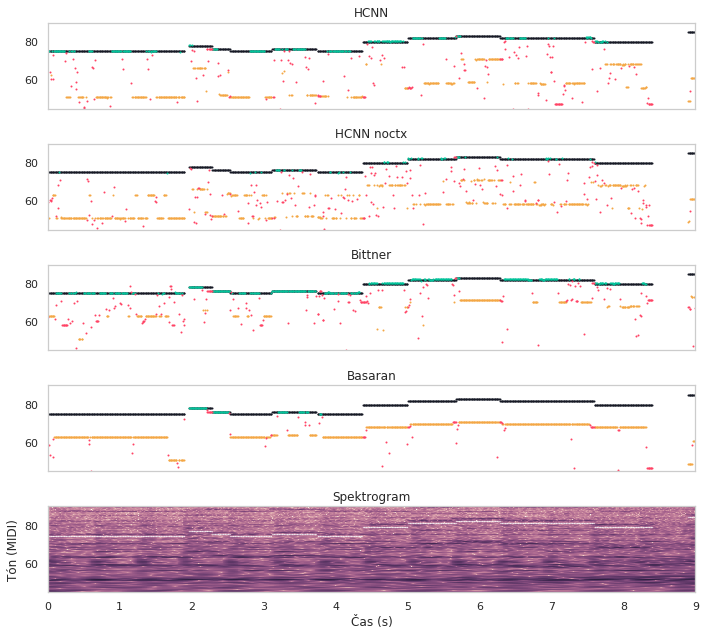

\begin{tabular}{ll}
\toprule
 Metrika (Metoda) & Musorgski-Ravel-PicturesExhibition-ex6 \\
\midrule
 RPA (HCNN noctx) &                                  0.103 \\
 RCA (HCNN noctx) &                                  0.759 \\
       RPA (HCNN) &                                  0.196 \\
       RCA (HCNN) &                                  0.814 \\
    RPA (Bittner) &                                  0.397 \\
    RCA (Bittner) &                                  0.826 \\
    RPA (Basaran) &                                  0.040 \\
    RCA (Basaran) &                                  0.914 \\
\bottomrule
\end{tabular}



In [38]:
# Protipříklad proti HCNN
dataset = "orchset"
track = "Musorgski-Ravel-PicturesExhibition-ex6"
compare(dataset, track, all_methods, xlim=(0, 9), ylim=(45, 90), show_player=False, show_spec=True)
to_latex(get_scores(dataset, track))

In [40]:
# Protipříklad proti HCNN
dataset = "orchset"
track = "Musorgski-Ravel-PicturesExhibition-ex6"
#show_salience(dataset, track, "test", "./models/0507_154235-spctrgrm-bs16-fw256-cw0-apw1-sus8-sos8-f16-s8-us2-os3/model-f0-saliences/", xlim=(0, 9))

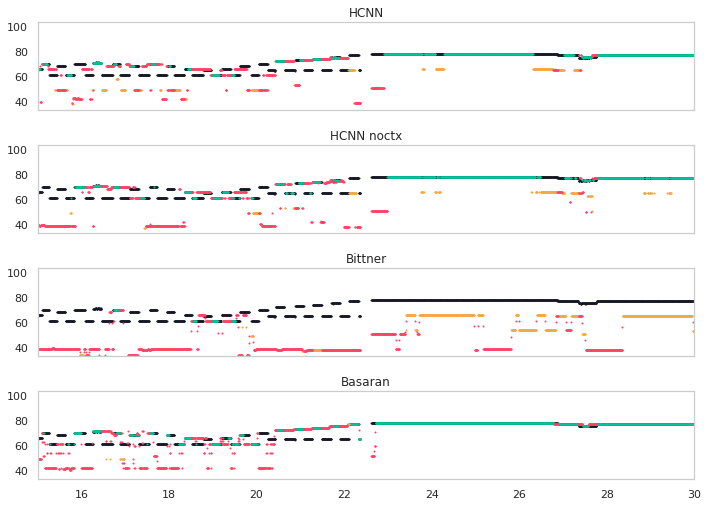

\begin{tabular}{ll}
\toprule
 Metrika (Metoda) & MatthewEntwistle\_FairerHopes \\
\midrule
 RPA (HCNN noctx) &                        0.428 \\
 RCA (HCNN noctx) &                        0.603 \\
       RPA (HCNN) &                        0.451 \\
       RCA (HCNN) &                        0.625 \\
    RPA (Bittner) &                        0.118 \\
    RCA (Bittner) &                        0.423 \\
    RPA (Basaran) &                        0.544 \\
    RCA (Basaran) &                        0.661 \\
\bottomrule
\end{tabular}



In [41]:
# Protipříklad Bittner 1
# harfa a dron
# harfa není v trénovacích datech
dataset = "mdb"
track = "MatthewEntwistle_FairerHopes"
compare(dataset, track, all_methods, xlim=(15, 30))
to_latex(get_scores(dataset, track))

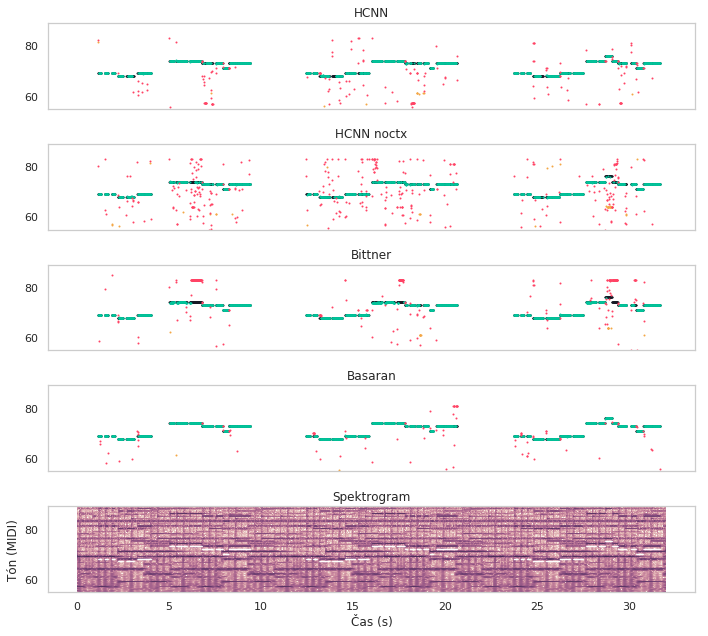

,train12
Metrika (Metoda),
RPA (HCNN noctx),0.801587
RCA (HCNN noctx),0.825926
RPA (HCNN),0.892063
RCA (HCNN),0.896825
RPA (Bittner),0.868783
RCA (Bittner),0.875661
RPA (Basaran),0.968783
RCA (Basaran),0.968783


In [42]:
# protipříklad já? Ale dát sem salienci
dataset = "mirex05"
track = "train12"
compare(dataset, track, all_methods, show_player=False, show_spec=True)
get_scores(dataset, track)

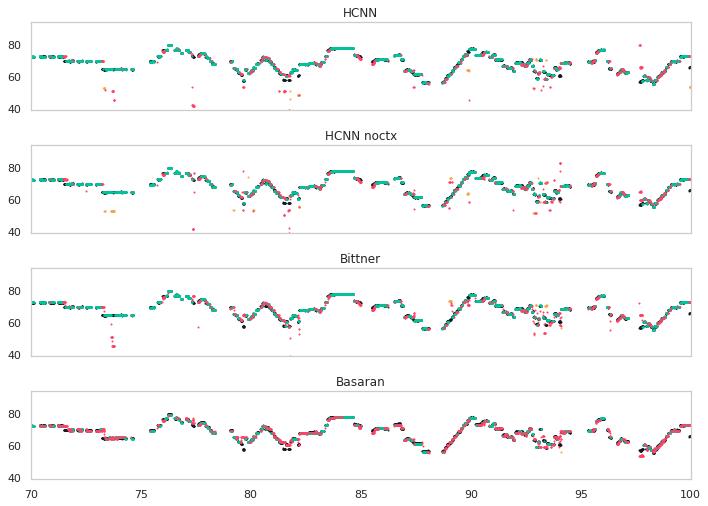

\begin{tabular}{ll}
\toprule
 Metrika (Metoda) & CannonballAdderley\_SoWhat \\
\midrule
 RPA (HCNN noctx) &                     0.848 \\
 RCA (HCNN noctx) &                     0.859 \\
       RPA (HCNN) &                     0.850 \\
       RCA (HCNN) &                     0.862 \\
    RPA (Bittner) &                     0.828 \\
    RCA (Bittner) &                     0.833 \\
    RPA (Basaran) &                     0.653 \\
    RCA (Basaran) &                     0.656 \\
\bottomrule
\end{tabular}



In [43]:
# Příklad proti Basaranovi
# jiné ladění, basaran je v prčicích
dataset = "wjazzd"
track = "CannonballAdderley_SoWhat"
compare(dataset, track, all_methods, xlim=(70, 100), show_player=False)
to_latex(get_scores(dataset, track))

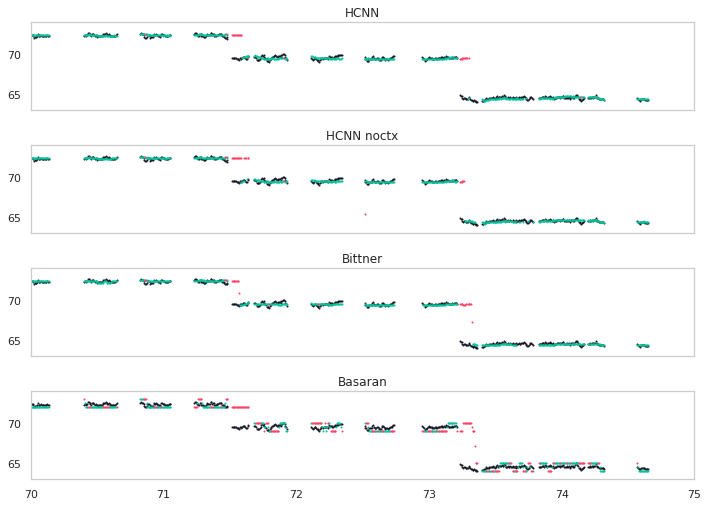

,CannonballAdderley_SoWh
Metrika (Metoda),
RPA (HCNN noctx),0.847724
RCA (HCNN noctx),0.859473
RPA (HCNN),0.850429
RCA (HCNN),0.861869
RPA (Bittner),0.827626
RCA (Bittner),0.833346
RPA (Basaran),0.653011
RCA (Basaran),0.656103


In [44]:
# Příklad proti Basaranovi
# jiné ladění, basaran je v prčicích
dataset = "wjazzd"
track = "CannonballAdderley_SoWh"
compare(dataset, track, all_methods, xlim=(70, 75), ylim=(63,74), show_player=False)
get_scores(dataset, track)

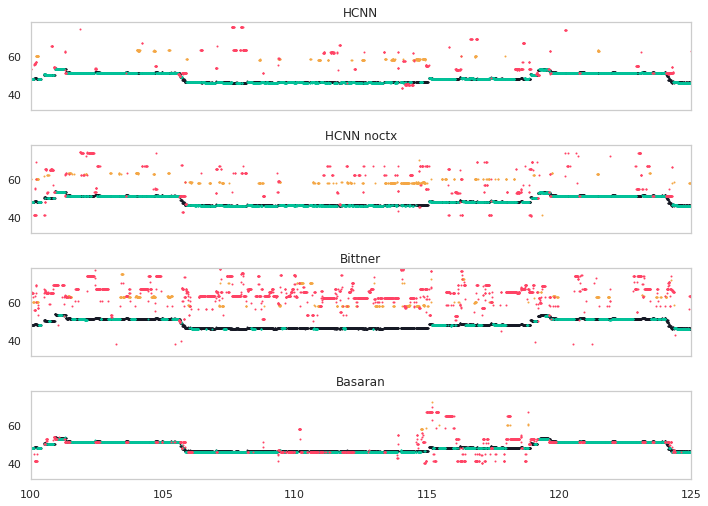

,AClassicEducation_NightOwl
Metrika (Metoda),
RPA (HCNN noctx),0.791633
RCA (HCNN noctx),0.838543
RPA (HCNN),0.843458
RCA (HCNN),0.869317
RPA (Bittner),0.659133
RCA (Bittner),0.717316
RPA (Basaran),0.782123
RCA (Basaran),0.792542


In [45]:
# Protipříklad bittner
dataset = "mdb"
track = "AClassicEducation_NightOwl"
compare(dataset, track, all_methods, show_player=False, xlim=(100, 125))
get_scores(dataset, track)
# kytarové akordy, Bittnerová je z akordů zmatená

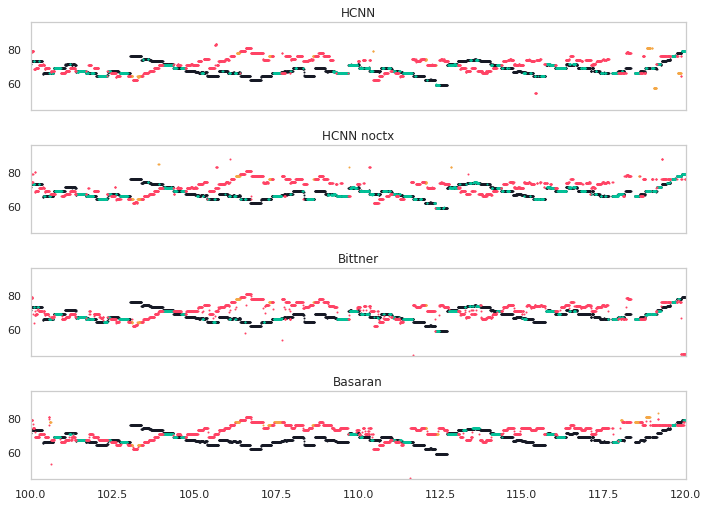

\begin{tabular}{ll}
\toprule
 Metrika (Metoda) & MusicDelta\_Pachelbel \\
\midrule
 RPA (HCNN noctx) &                0.460 \\
 RCA (HCNN noctx) &                0.506 \\
       RPA (HCNN) &                0.455 \\
       RCA (HCNN) &                0.499 \\
    RPA (Bittner) &                0.461 \\
    RCA (Bittner) &                0.493 \\
    RPA (Basaran) &                0.435 \\
    RCA (Basaran) &                0.491 \\
\bottomrule
\end{tabular}



In [46]:
# protipříklad proti anotacím
dataset = "mdb"
track = "MusicDelta_Pachelbel"
compare(dataset, track, all_methods, xlim=(100, 120))
to_latex(get_scores(dataset, track))

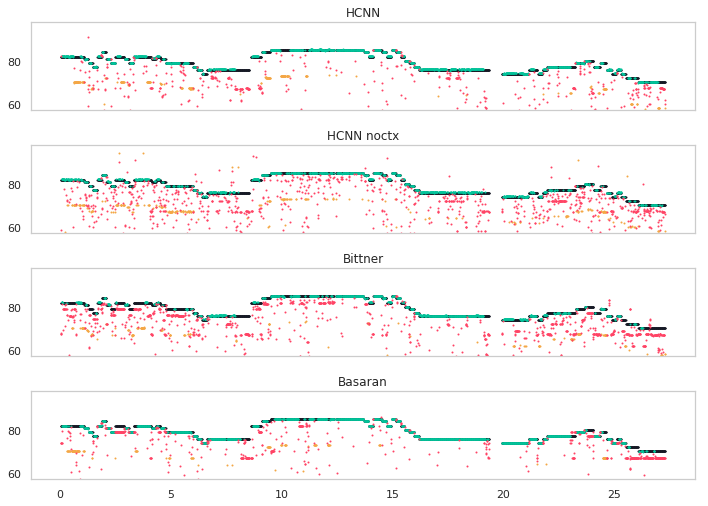

,Ravel-Bolero-ex3
Metrika (Metoda),
RPA (HCNN noctx),0.497906
RCA (HCNN noctx),0.608298
RPA (HCNN),0.67834
RCA (HCNN),0.774267
RPA (Bittner),0.475828
RCA (Bittner),0.543586
RPA (Basaran),0.723258
RCA (Basaran),0.776932


In [47]:
dataset = "orchset"
track = "Ravel-Bolero-ex3"
compare(dataset, track, all_methods, show_player=False)
get_scores(dataset, track)

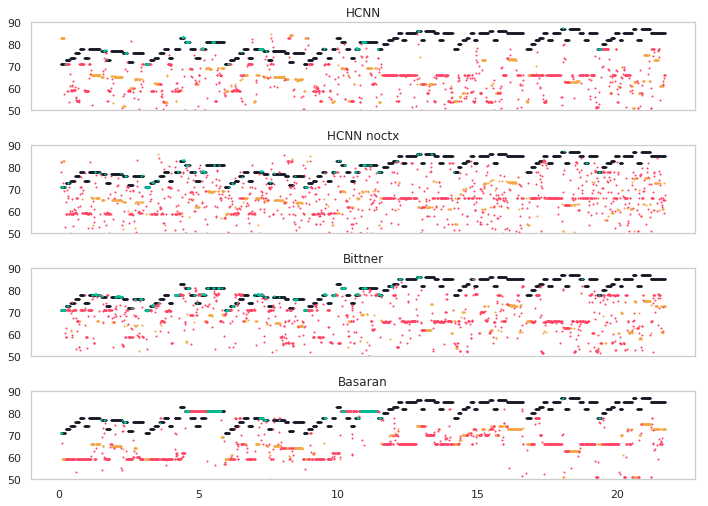

,Grieg-PeerGynt-HallMountainKing-ex1
Metrika (Metoda),
RPA (HCNN noctx),0.0765027
RCA (HCNN noctx),0.345256
RPA (HCNN),0.0710383
RCA (HCNN),0.390462
RPA (Bittner),0.165425
RCA (Bittner),0.345256
RPA (Basaran),0.101341
RCA (Basaran),0.381023


In [48]:

dataset = "orchset"
track = "Grieg-PeerGynt-HallMountainKing-ex1"
compare(dataset, track, all_methods, show_player=False, ylim=(50, 90))
get_scores(dataset, track)

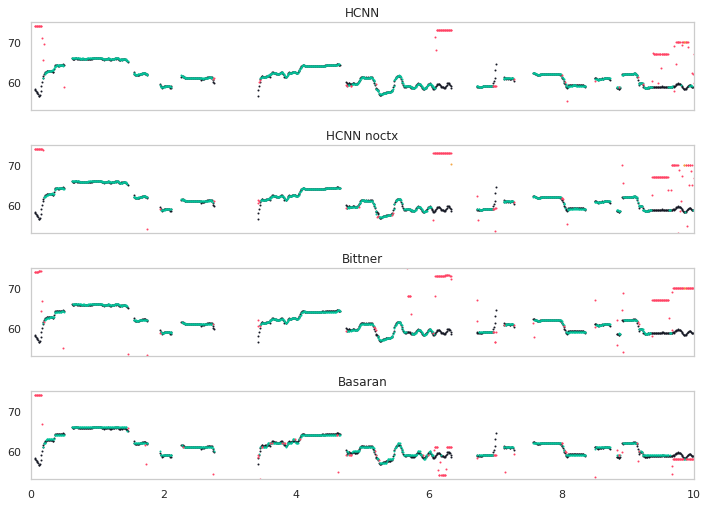

,train01
Metrika (Metoda),
RPA (HCNN noctx),0.863237
RCA (HCNN noctx),0.872647
RPA (HCNN),0.890841
RCA (HCNN),0.897114
RPA (Bittner),0.861982
RCA (Bittner),0.864492
RPA (Basaran),0.865119
RCA (Basaran),0.865119


In [49]:
dataset = "mirex05"
track = "train01"
compare(dataset, track, all_methods, show_player=False, xlim=(0, 10), ylim=(53,75))
get_scores(dataset, track)